# Clustering

In [19]:
# Import KMeans from sklearn.cluster
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# import final data from eda
%store -r final_data

In [20]:
COLUMNS = [
    "GDP per capita (current US$)",
    "Economy: Agriculture (% of GVA)",
    "Population growth rate (average annual %)",
    "Urban population (% of total population)",
    "Infant mortality rate (per 1000 live births"
]
cluster_data = final_data[COLUMNS]
cluster_data.shape

(191, 5)

In [21]:
# Guess the Number of Clusters
num_clust = 3

# # Create Clustering Model using KMeans
kmeans = KMeans(n_clusters = num_clust)

# # Fit the Clustering Model on the Final Data
kmeans.fit(cluster_data)

KMeans(n_clusters=3)

In [22]:
# Print the Cluster Centers
print("Features", "insert array of features")
print()

for i, center in enumerate(kmeans.cluster_centers_):
    print("Cluster", i, end=":\t")
    for coord in center:
        print(round(coord, 2), end="\t")
    print()

Features insert array of features

Cluster 0:	6113.47	14.0	1.46	52.11	30.15	
Cluster 1:	48184.13	1.51	1.13	85.07	4.87	
Cluster 2:	167681.2	4.32	0.7	57.15	18.0	


#### Within Cluster Sum of Squares

WithinSS = 0 : Every data point is a cluster on its own    
WithinSS = Variance : Whole dataset is a single cluster

In [23]:
# Print the Within Cluster Sum of Squares
print("Within Cluster Sum of Squares :", kmeans.inertia_)

Within Cluster Sum of Squares : 13508419669.078186


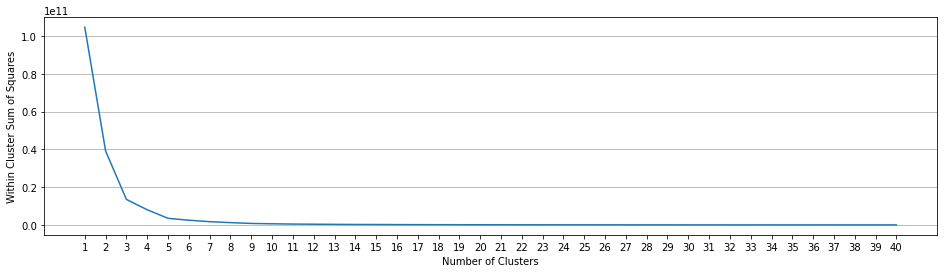

In [24]:
# Vary the Number of Clusters
min_clust = 1
max_clust = 40

# Compute Within Cluster Sum of Squares
within_ss = []
for num_clust in range(min_clust, max_clust+1):
    kmeans = KMeans(n_clusters = num_clust)
    kmeans.fit(cluster_data)
    within_ss.append(kmeans.inertia_)

# Plot Within SS vs Number of Clusters
f = plt.figure(figsize=(16,4))
plt.plot(range(min_clust, max_clust+1), within_ss)
plt.xlabel('Number of Clusters')
plt.ylabel('Within Cluster Sum of Squares')
plt.xticks(np.arange(min_clust, max_clust+1, 1.0))
plt.grid(which='major', axis='y')
plt.show()